In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, LSTM
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential, load_model, Model

import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model

# Data Preparation

In [3]:

# Load and prepare the dataset
file_path = 'Reliance.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
df.dropna(inplace=True)
data = df[['Adj Close']].values
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-18,463.799988,465.649994,454.975006,456.000000,436.671021,5142766.0
1,2015-11-19,459.450012,469.350006,458.625000,467.375000,447.563873,5569752.0
2,2015-11-20,467.000000,476.399994,462.774994,473.424988,453.357422,5167930.0
3,2015-11-23,475.000000,478.950012,473.100006,476.875000,456.661224,4800026.0
4,2015-11-24,476.500000,485.799988,475.524994,483.850006,463.340515,6768886.0
...,...,...,...,...,...,...,...
1228,2020-11-10,2077.000000,2090.000000,2041.199951,2084.550049,2084.550049,17045147.0
1229,2020-11-11,2089.000000,2095.000000,1978.099976,1997.199951,1997.199951,26178477.0
1230,2020-11-12,1981.000000,2008.449951,1965.000000,1980.000000,1980.000000,18481466.0
1231,2020-11-13,1982.000000,2036.650024,1981.750000,1996.400024,1996.400024,20946864.0


In [4]:
# Scaling and normalizing values
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.00138031],
       [0.00714224],
       [0.01020682],
       ...,
       [0.81774549],
       [0.82642051],
       [0.82475426]])

In [5]:
# Making data suitable for modelling
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# Parameters
time_step = 100
training_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Transformer Block

In [8]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

In [9]:
# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

transformer = Model(inputs=inputs, outputs=outputs)
transformer.compile(optimizer="adam", loss="mean_squared_error")

In [10]:
# Model Summary
transformer.summary()

# Train the model
transformer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 1)    │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 1)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 4)    │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 4)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 1)    │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 1)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │      2,020 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,227 (36.04 KB)

 Trainable params: 9,227 (36.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.0145

KeyboardInterrupt: 

In [16]:
# Make predictions
train_predict = transformer.predict(X_train)
test_predict = transformer.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# Inverse only the corresponding true values (already trimmed)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


In [17]:
# Evaluation
mse = mean_squared_error(y_test_inv, test_predict)
r2 = r2_score(y_test_inv, test_predict)
mae = mean_absolute_error(y_test_inv, test_predict)
print('Mean Absolute Error = ', mae)
print('Root Mean Squared Error = ', math.sqrt(mse))
print('Mean Squared Error = ', mse)
print('R-Squared = ', r2)
print("Shapes:", y_test_inv.shape, test_predict.shape)


Mean Absolute Error =  102.1811174415339
Root Mean Squared Error =  133.61003550331077
Mean Squared Error =  17851.64158719596
R-Squared =  0.861045818973927
Shapes: (306, 1) (306, 1)


In [18]:
# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

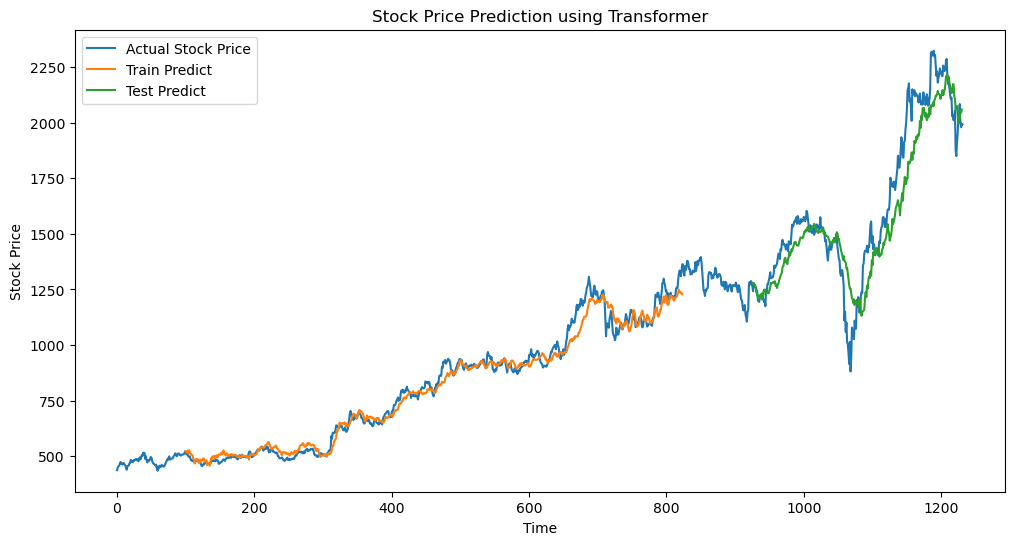

In [19]:
# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# LSTM Block

In [11]:
# Model Definition
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2]), 
              activation='relu', 
              return_sequences=False))

lstm.add(keras.layers.Dropout(0.1))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# Model Fitting
history = lstm.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    verbose=1,
    shuffle=False,
)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


c:\Users\nida5\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 6.6822e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0094
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0060
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0034
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0012
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.2691e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.4441e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.5798e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.6057e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9245e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.8023e-04
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.3412e-04
Epoch 13/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2040e-04
Epoch 14/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9481e-04
Epoch 15/50
91/91 ━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


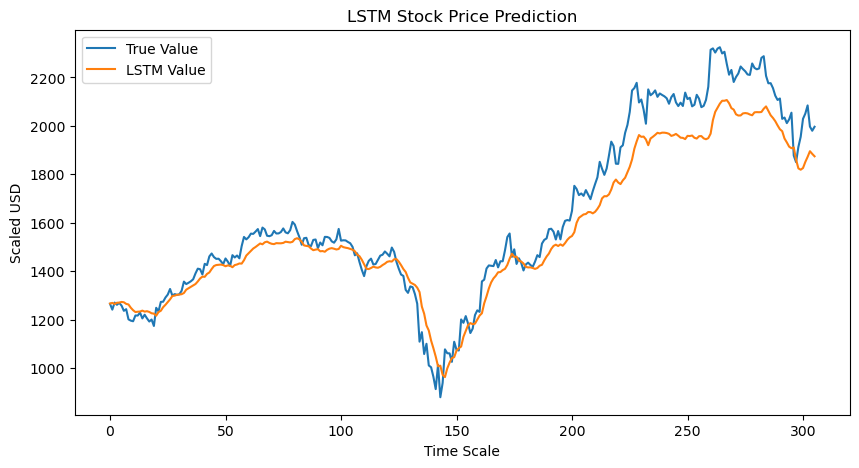

In [12]:
y_pred = lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='True Value')
plt.plot(y_pred_lstm, label='LSTM Value')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.title('LSTM Stock Price Prediction')
plt.legend()
plt.show()


In [13]:
# Evaluate the model
MSE_lstm = mean_squared_error(y_test_inv, y_pred_lstm)
MAE_lstm = mean_absolute_error(y_test_inv, y_pred_lstm)
print('Mean Absolute Error (LSTM) = ', MAE_lstm)
print('Root Mean Squared Error (LSTM) = ', math.sqrt(MSE_lstm))
r2_lstm = r2_score(y_test_inv, y_pred_lstm)
print('Mean Squared Error = ', MSE_lstm)
print('R-Squared (LSTM) = ', r2_lstm)

Mean Absolute Error (LSTM) =  80.58895296820108
Root Mean Squared Error (LSTM) =  104.57100882865717
Mean Squared Error =  10935.095887443094
R-Squared (LSTM) =  0.9148830494910296


# Hybrid Model

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      1,793 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 1)    │          0 │ input_layer_2[0]… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100, 128)  │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 100, 128)  │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 100, 1)    │        129 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 1)    │          0 │ add_2[0][0],      │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 1)    │      1,793 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 1)    │          0 │ add_3[0][0],      │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 1)    │          2 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 100, 128)  │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 100, 128)  │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 1)    │        129 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 100, 1)    │          0 │ add_4[0][0],      │
│                     │                   │            │ dense_8[0][0]   

 Total params: 29,325 (114.55 KB)

 Trainable params: 29,325 (114.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - loss: 0.0320 - val_loss: 0.0058
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - loss: 6.7564e-04 - val_loss: 0.0037
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 6.7579e-04 - val_loss: 0.0025
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - loss: 6.1315e-04 - val_loss: 0.0026
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 5.5920e-04 - val_loss: 0.0036
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 8.3196e-04 - val_loss: 0.0029
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 5.3173e-04 - val_loss: 0.0026
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 6.1732e-04 - val_loss: 0.0022
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 5.6076e-04 - val_loss: 0.0018
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 6.0876e-04 - val_loss: 0.0018
Epoch 12/50
23/

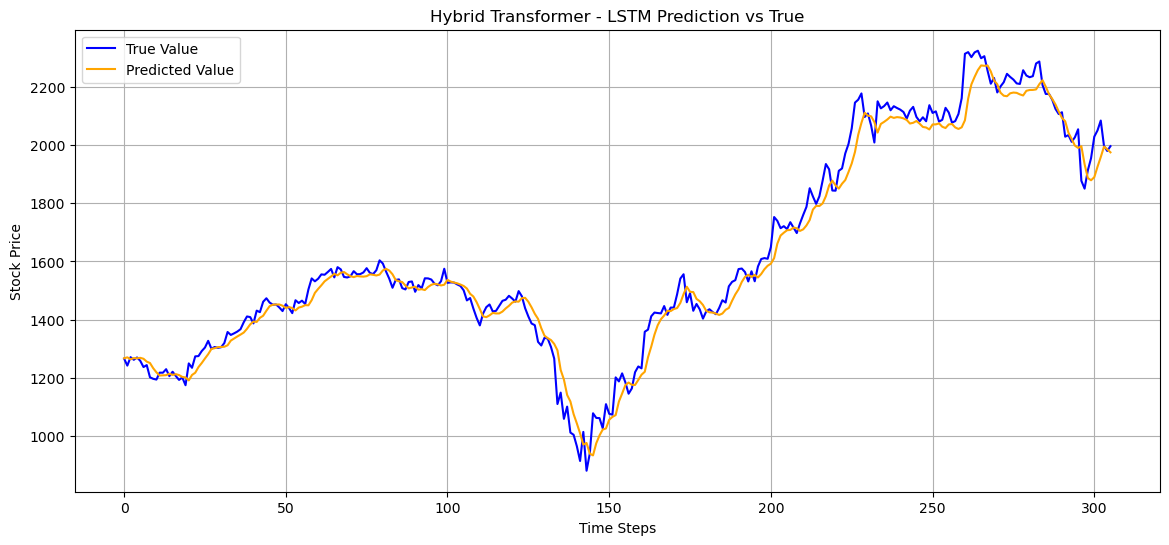

Text(0, 0.5, 'MSE')

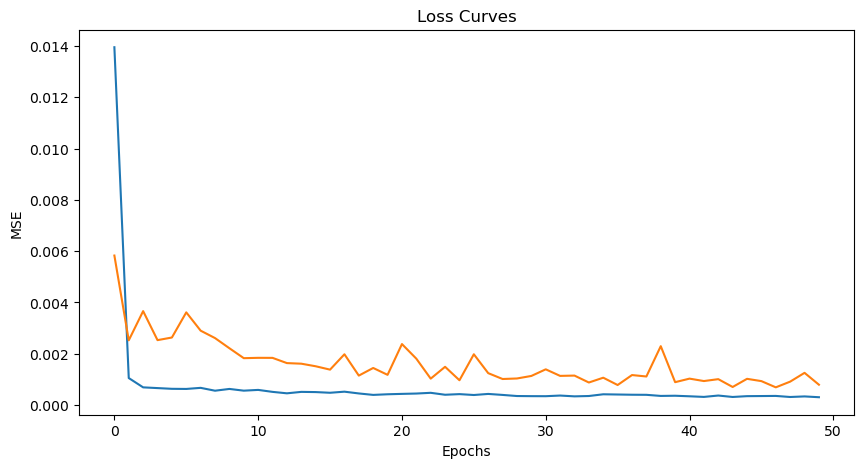

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, LayerNormalization, MultiHeadAttention, Add, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --- Transformer Encoder Block ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([inputs, x])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([res, x])

# === Input ===
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (timesteps, features)

# === Transformer Stage ===
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# === Intermediate Dense to reduce dimensionality ===
x = Dense(32, activation='relu')(x)

# === Reshape for LSTM input ===
x = Reshape((X_train.shape[1], 32))(x)  # reshape for LSTM compatibility

# === LSTM Stage ===
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)

# === Output Layer ===
output = Dense(1, activation='linear')(x)

# === Model Definition ===
model = Model(inputs, output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# === Training ===
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    verbose=1)

# === Prediction ===
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))




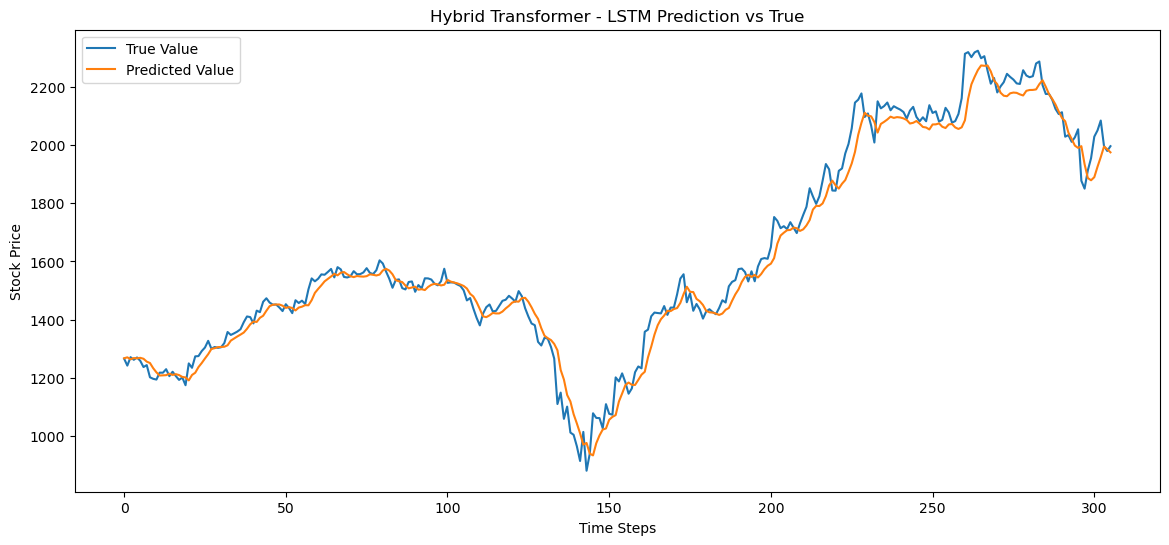

Text(0, 0.5, 'MSE')

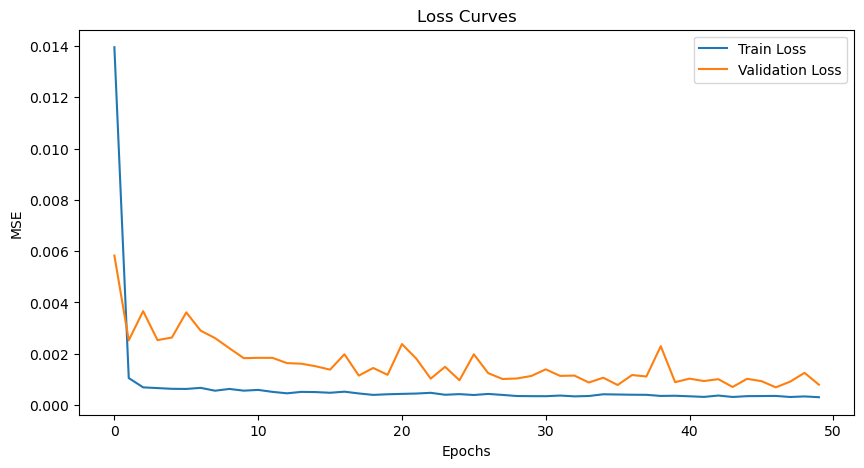

In [26]:
# === Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='True Value')
plt.plot(y_pred_inv, label='Predicted Value')
plt.title('Hybrid Transformer - LSTM Prediction vs True')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# === Loss Curves ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [27]:
mse_hybrid = mean_squared_error(y_test_inv, y_pred_inv)
mae_hybrid = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Absolute Error (Hybrid) = ', mae_hybrid)
print('Root Mean Squared Error (Hybrid) = ', math.sqrt(mse_hybrid))
r2_hybrid = r2_score(y_test_inv, y_pred_inv)
print('Mean-Squared Error = ',mse_hybrid)
print('R-Squared = ',r2_hybrid)

Mean Absolute Error (Hybrid) =  38.898261795572914
Root Mean Squared Error (Hybrid) =  53.06288992330671
Mean-Squared Error =  2815.6702870129648
R-Squared =  0.9780832952050775


# Validating with Tesla Dataset

In [28]:
tesla = pd.read_csv('TSLA.csv')
tesla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [29]:
tesla.dropna(inplace=True)
tesla = tesla[['Adj Close']].values
# Scaling and normalizing values
scaler = MinMaxScaler(feature_range=(0,1))
tesla_scaled = scaler.fit_transform(tesla)
tesla_scaled

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.80767879],
       [0.81186057],
       [0.82393312]])

In [30]:
# Parameters
time_step = 100
X_tesla, y_tesla = create_dataset(tesla_scaled, time_step)

# Reshape input for the model
X_tesla = X_tesla.reshape(X_tesla.shape[0], X_tesla.shape[1], 1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step
Mean Absolute Error =  16.97043573959185
Root Mean Squared Error =  32.22028403497874
Mean Squared Error =  1038.146703294706
R-Squared =  0.9837359933504304
Shapes: (2855, 1) (2855, 1)


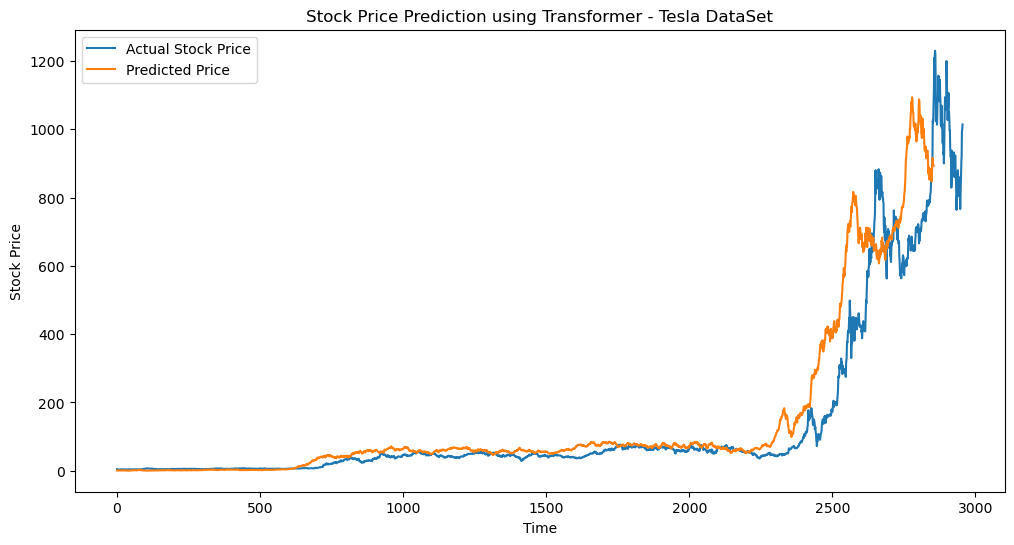

In [32]:

tesla_predict = transformer.predict(X_tesla)

# Inverse transform predictions
tesla_predict = scaler.inverse_transform(tesla_predict)

# Inverse only the corresponding true values (already trimmed)
y_tesla_inv = scaler.inverse_transform(y_tesla.reshape(-1, 1))

# Evaluation
mse_tesla = mean_squared_error(y_tesla_inv, tesla_predict)
mae_tesla = mean_absolute_error(y_tesla_inv, tesla_predict)
rmse_tesla = math.sqrt(mse_tesla)
print('Mean Absolute Error = ', mae_tesla)
print('Root Mean Squared Error = ', rmse_tesla)
r2_tesla = r2_score(y_tesla_inv, tesla_predict)
print('Mean Squared Error = ', mse_tesla)
print('R-Squared = ', r2_tesla)
print("Shapes:", y_tesla_inv.shape, tesla_predict.shape)


# Plotting the results

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(tesla_scaled), label='Actual Stock Price')
plt.plot(tesla_predict, label='Predicted Price')
plt.title('Stock Price Prediction using Transformer - Tesla DataSet')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


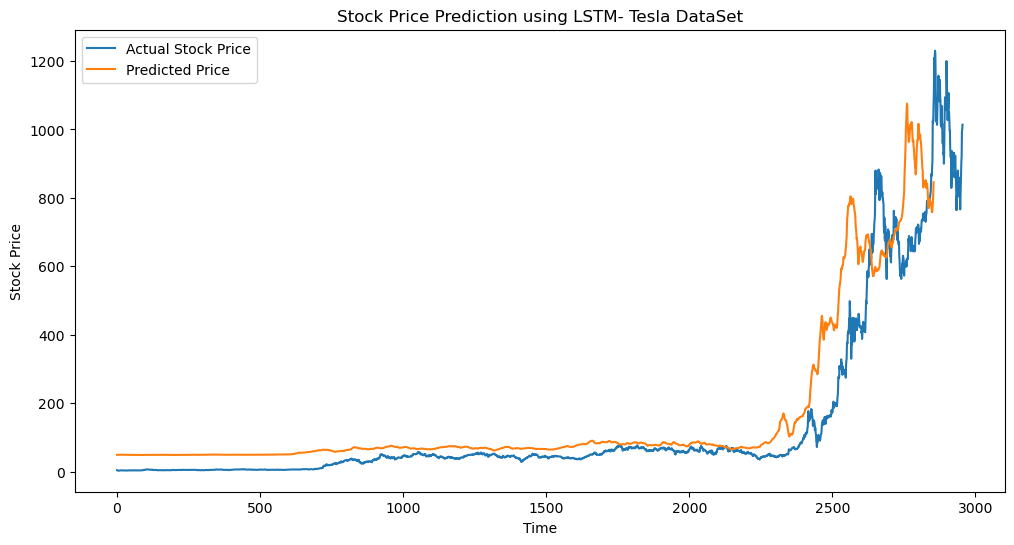

In [33]:
tesla_pred_lstm = lstm.predict(X_tesla)
tesla_pred_lstm = scaler.inverse_transform(tesla_pred_lstm)


# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(tesla_scaled), label='Actual Stock Price')
plt.plot(tesla_pred_lstm, label='Predicted Price')
plt.title('Stock Price Prediction using LSTM- Tesla DataSet')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [34]:
# Evaluation
mse_tesla_lstm = mean_squared_error(y_tesla_inv, tesla_pred_lstm)
mae_tesla_lstm = mean_absolute_error(y_tesla_inv, tesla_pred_lstm)
rmse_tesla_lstm = math.sqrt(mse_tesla_lstm) 
print('Mean Absolute Error = ', mae_tesla_lstm)
print('Root Mean Squared Error = ', rmse_tesla_lstm)
r2_tesla_lstm = r2_score(y_tesla_inv, tesla_pred_lstm)
print('Mean Squared Error = ', mse_tesla_lstm)
print('R-Squared = ',r2_tesla_lstm)


Mean Absolute Error =  30.564931058861667
Root Mean Squared Error =  36.668005708931794
Mean Squared Error =  1344.5426426702545
R-Squared =  0.978935876392403


90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step


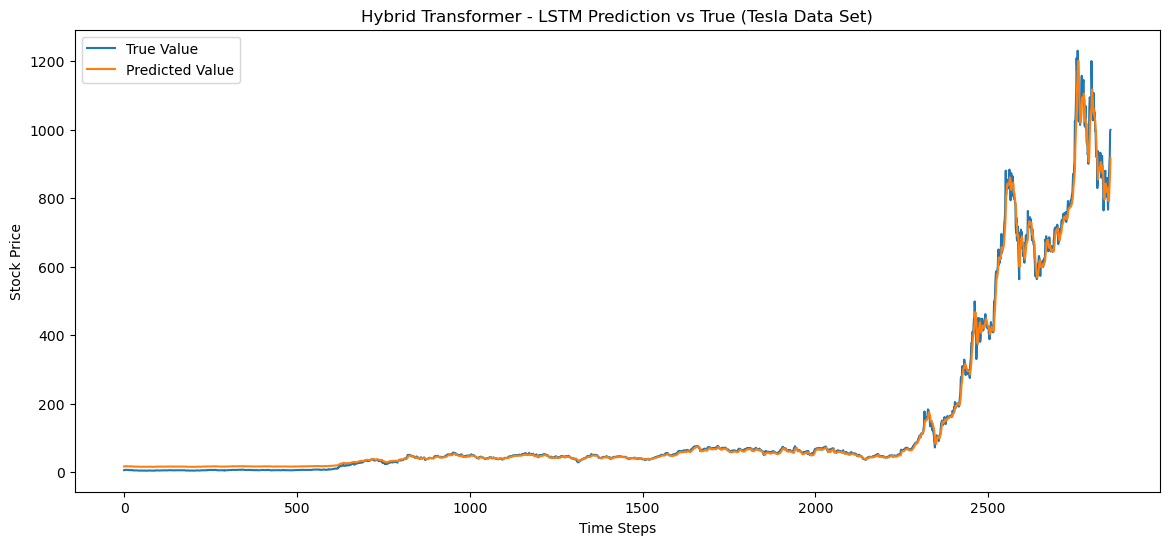

In [36]:
y_pred_hybrid = model.predict(X_tesla)
y_pred_inv_hybrid = scaler.inverse_transform(y_pred_hybrid.reshape(-1, 1))
y_tesla_inv = scaler.inverse_transform(y_tesla.reshape(-1, 1))

# === Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(y_tesla_inv, label='True Value')
plt.plot(y_pred_inv_hybrid, label='Predicted Value')
plt.title('Hybrid Transformer - LSTM Prediction vs True (Tesla Data Set)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [37]:
# Evaluation
mse_tesla_hybrid = mean_squared_error(y_tesla_inv, y_pred_inv_hybrid)
mae_tesla_hybrid = mean_absolute_error(y_tesla_inv, y_pred_inv_hybrid)
rmse_tesla_hybrid = math.sqrt(mse_tesla_hybrid) 
print('Mean Absolute Error = ', mae_tesla_hybrid)
print('Root Mean Squared Error = ', rmse_tesla_hybrid) 
r2_tesla_hybrid = r2_score(y_tesla_inv, y_pred_inv_hybrid)
print('Mean Squared Error = ', mse_tesla_hybrid)
print('R-Squared = ',r2_tesla_hybrid)


Mean Absolute Error =  8.089112803982486
Root Mean Squared Error =  15.669983191314554
Mean Squared Error =  245.54837321608062
R-Squared =  0.9961531444813116


# Validation using INTEL

In [38]:
intel = pd.read_csv('INTC.csv')
intel

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.199557,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.197961,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.202750,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.201952,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.194767,12172800
...,...,...,...,...,...,...,...
10356,2021-04-13,65.610001,65.629997,64.209999,65.220001,65.220001,26822000
10357,2021-04-14,65.309998,65.379997,63.840000,64.190002,64.190002,25768400
10358,2021-04-15,63.970001,65.220001,63.680000,65.019997,65.019997,24927700
10359,2021-04-16,65.330002,65.519997,64.570000,64.750000,64.750000,24607000


In [39]:
intel.dropna(inplace=True)
intel = intel[['Adj Close']].values
# Scaling and normalizing values
scaler = MinMaxScaler(feature_range=(0,1))
intel_scaled = scaler.fit_transform(intel)
intel_scaled

array([[0.0009842 ],
       [0.00096077],
       [0.00103106],
       ...,
       [0.95244203],
       [0.94847892],
       [0.93203917]])

In [40]:
# Parameters
time_step = 100
X_intel, y_intel = create_dataset(intel_scaled, time_step)

# Reshape input for the model
X_intel = X_intel.reshape(X_intel.shape[0], X_intel.shape[1], 1)

321/321 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step
Mean Absolute Error =  0.7853429125875561
Root Mean Squared Error =  1.361241170216703
Mean Squared Error =  1.8529775234929395
R-Squared =  0.9915656021122482
Shapes: (10260, 1) (10260, 1)


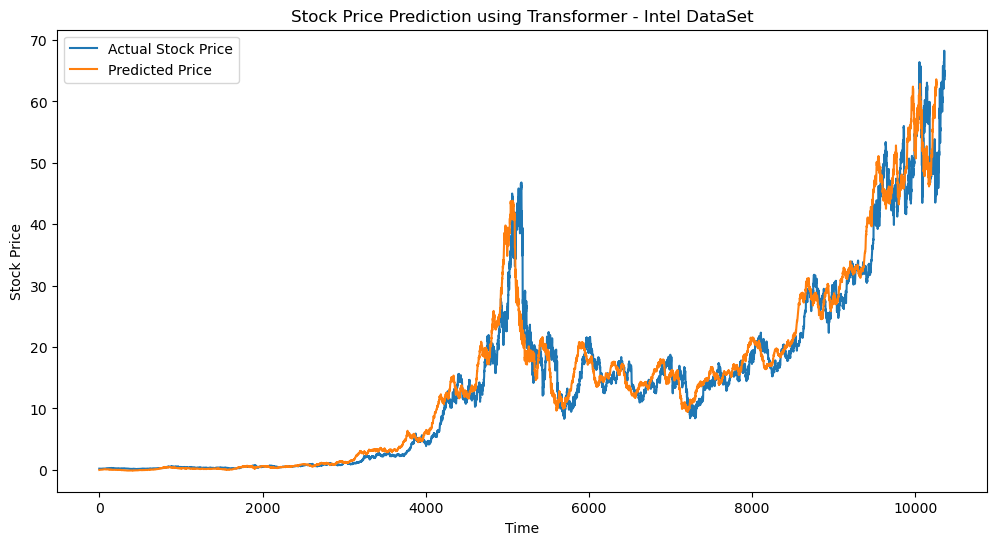

In [41]:

intel_predict = transformer.predict(X_intel)

# Inverse transform predictions
intel_predict = scaler.inverse_transform(intel_predict)

# Inverse only the corresponding true values (already trimmed)
y_intel_inv = scaler.inverse_transform(y_intel.reshape(-1, 1))

# Evaluation
mse_intel = mean_squared_error(y_intel_inv, intel_predict)
mae_intel = mean_absolute_error(y_intel_inv, intel_predict)
rmse_intel = math.sqrt(mse_intel)
print('Mean Absolute Error = ', mae_intel)
print('Root Mean Squared Error = ', rmse_intel) 
r2_intel = r2_score(y_intel_inv, intel_predict)
print('Mean Squared Error = ', mse_intel)
print('R-Squared = ', r2_intel)
print("Shapes:", y_intel_inv.shape, intel_predict.shape)


# Plotting the results

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(intel_scaled), label='Actual Stock Price')
plt.plot(intel_predict, label='Predicted Price')
plt.title('Stock Price Prediction using Transformer - Intel DataSet')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


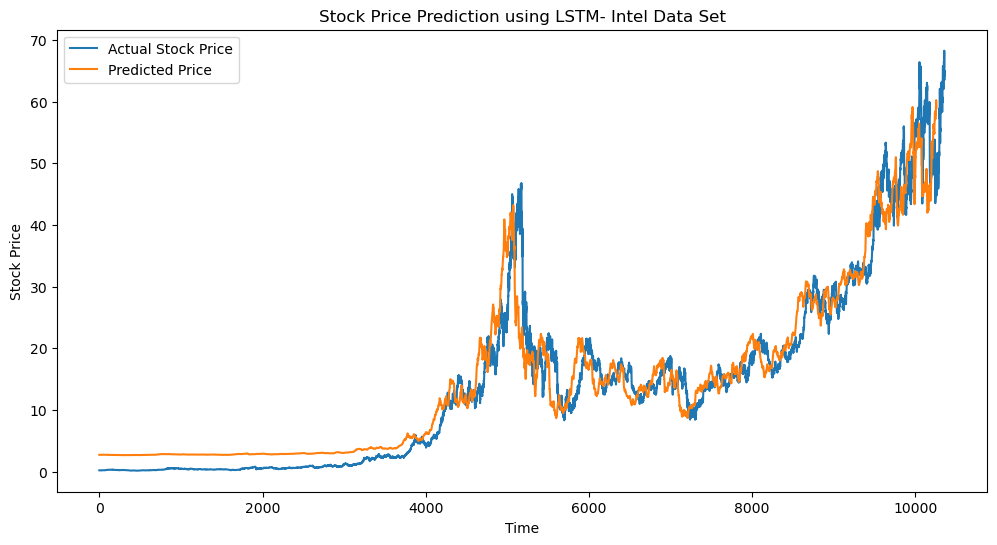

In [42]:
intel_pred_lstm = lstm.predict(X_intel)
intel_pred_lstm = scaler.inverse_transform(intel_pred_lstm)


# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(intel_scaled), label='Actual Stock Price')
plt.plot(intel_pred_lstm, label='Predicted Price')
plt.title('Stock Price Prediction using LSTM- Intel Data Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [43]:
# Evaluation
mse_intel_lstm = mean_squared_error(y_intel_inv, intel_pred_lstm)
r2_intel_lstm = r2_score(y_intel_inv, intel_pred_lstm)
mae_intel_lstm = mean_absolute_error(y_intel_inv, intel_pred_lstm)
rmse_intel_lstm = math.sqrt(mse_intel_lstm) 
print('Mean Absolute Error = ', mae_intel_lstm)
print('Root Mean Squared Error = ', rmse_intel_lstm)   
print('Mean Squared Error = ', mse_intel_lstm)
print('R-Squared = ',r2_intel_lstm)


Mean Absolute Error =  1.421673815473769
Root Mean Squared Error =  1.891323106338914
Mean Squared Error =  3.5771030925714786
R-Squared =  0.9837177135795029


321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step


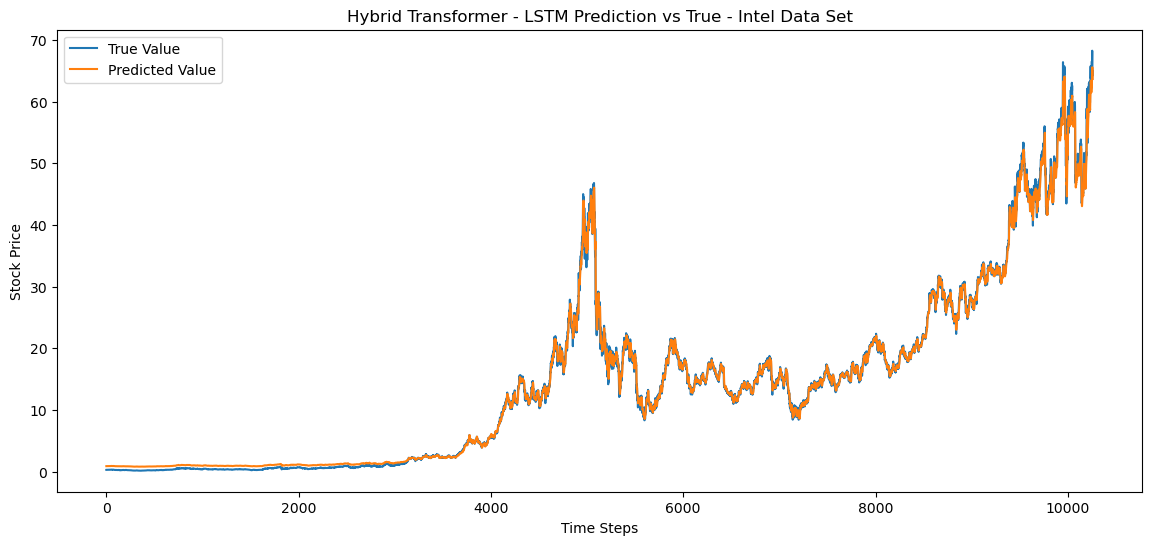

In [45]:
intel_pred_hybrid = model.predict(X_intel)
intel_pred_hybrid = scaler.inverse_transform(intel_pred_hybrid.reshape(-1, 1))

# === Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(y_intel_inv, label='True Value')
plt.plot(intel_pred_hybrid, label='Predicted Value')
plt.title('Hybrid Transformer - LSTM Prediction vs True - Intel Data Set')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [46]:
# Evaluation
mse_intel_hybrid = mean_squared_error(y_intel_inv, intel_pred_hybrid)
mae_intel_hybrid = mean_absolute_error(y_intel_inv, intel_pred_hybrid)
rmse_intel_hybrid = math.sqrt(mse_intel_hybrid) 
print('Mean Absolute Error = ', mae_intel_hybrid)
print('Root Mean Squared Error = ', rmse_intel_hybrid)
r2_intel_hybrid = r2_score(y_intel_inv, intel_pred_hybrid)
print('Mean Squared Error = ', mse_intel_hybrid)
print('R-Squared = ',r2_intel_hybrid)

Mean Absolute Error =  0.48542290635072927
Root Mean Squared Error =  0.714216242640887
Mean Squared Error =  0.5101048412520663
R-Squared =  0.9976781007103216
